In [3]:
import numpy as np
# import pathogenprofiler as pp
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
# import fastq2matrix as fm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from scipy.stats import norm
import subprocess
from scipy.stats import kurtosis, skew
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cb91visuals import *


In [4]:
vcf_file = 'test_data/ERR6634978-ERR6635032-2080.vcf.gz'
json_file = 'test_data/ERR6634978-ERR6635032-2080.results.json'

In [5]:
VCF_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20
JSON_FILE_PATH='/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/results'
#/mnt/storage7/lwang/trial_tb_philippines/data/processed/seqtk/freebayesVCF/q20/results

NAME_FILE='/mnt/storage7/lwang/trial_tb_philippines/data/seqtk/sample_name.txt'

In [6]:
def anchor(VCF_FILE_PATH):
    #load vcf
    with open('ROAO_DP_ALT.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '[%%POS,%%REF,%%ALT,%%GT,%%AD,%%DP\\n]'" % VCF_FILE_PATH, shell=True, stdout=f, text=True)

    with open('ROAO_DP_ALT.csv', 'r') as f:
        data = []
        num_col=0
        for line in f:
            data_line = line.rstrip().split('\n')
            data_line = data_line[0].split(',')
            data_line = [i for i in data_line]
            if len(data_line) > num_col:
                num_col = len(data_line)
            data.append(data_line)

    #loading established database
    with open('fst_results_clean_fst_1_for_paper.csv','r') as f:
        barcode = []
        for line in f:
            data_line = line.rstrip().split(',')
            data_line = [i for i in data_line]
            barcode.append(data_line)

    df_bar = pd.DataFrame(barcode)
    df_bar = df_bar.iloc[1:, :8]
    df_bar.drop([0,3,4,5,6], axis=1, inplace=True)

    df_bar['lin_'] = 'other'
    for i, x in enumerate(df_bar[1]):
        if re.search("^[1-9]", x):
            df_bar['lin_'][i]=re.search('^[1-9]',x).group()
        # else re.search("^[1-9]", x)==None:

        else:
            df_bar['lin_'][i]='other'

    df_bar = df_bar[df_bar['lin_']!='other']
    df_bar_array = np.array(df_bar)

    #load data vcf
    data1 = []

    for i in data:
        if len(i) == 7:
            data1.append(i)
    data1_array = np.array(data1)

    data1_array=np.delete(data1_array, 3, 1)

    anchored = []
    for x in data1_array:
        for y in df_bar_array:
            if int(x[0]) >= int(y[1]) and int(x[0]) < int(y[1])+2 and x[2] == y[2]:
                insert = np.append(x, y[3])
                anchored.append(insert)
                pass

    anchored_array = np.array(anchored)
    anchored_lineage = anchored_array[:, 6]
    anchored_lineage = anchored_lineage.astype(float)

    anchored_snp =  anchored_array[:, 3:5]
    anchored_snp = anchored_snp.astype(float)

    return anchored_snp, anchored_lineage       
      
anchored_snp, anchored_lineage = anchor(vcf_file)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Ubuntu


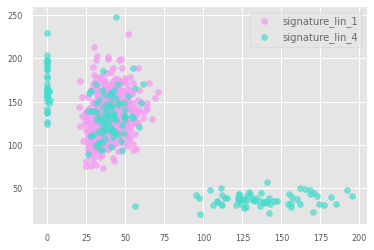

In [7]:
anchored_array = np.concatenate((anchored_snp, anchored_lineage.reshape(-1,1)), axis=1) 

lin1_ = anchored_array[anchored_array[:,2]==1]
lin4_ = anchored_array[anchored_array[:,2]==4]

with plt.style.context('ggplot'):

    plt.scatter(lin1_[:,0], lin1_[:,1], c=CB91_Pink, alpha=0.8, label='signature_lin_1')
    plt.scatter(lin4_[:,0], lin4_[:,1], c=CB91_Green, alpha=0.7, label='signature_lin_4')

    plt.legend(loc="upper right")


In [53]:
def assign_variant_to_distrib(km,freq):
    pred = km.predict([[freq]])
    return pred[0]


In [9]:
tb_profiler_predictions = []

def tb_profiler_pred(json_file):
    output = []
    json_results = json.load(open(json_file))
    for x in json_results['lineage']:
        if re.search("^lineage1.2.1$", x['lin']):
            output.append(x['frac'])
        if re.search("^lineage4.3.4$", x['lin']):
            output.append(x['frac'])
        
    if len(output) == 1:
        output.append(0)
    if output[0] < output[1]:
        temp = output[0]
        output[0] = output[1]
        output[1] = temp
    if output[0] > output[1]:
        cut_off =  output[1]/2
    else:
        cut_off =  output[-2]/2

    return output, cut_off


print(tb_profiler_pred(json_file))

([0.7554125219426565, 0.20933977455716588], 0.10466988727858294)


([0.797940797940798, 0.20205920205920205], KMeans(init='random', n_clusters=2, random_state=0), KMeans(init='random', n_clusters=2, random_state=0))


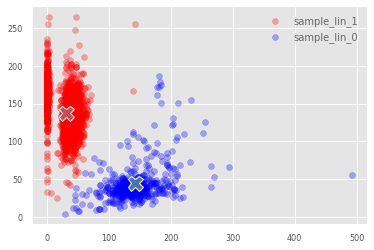

In [68]:
model_predictions = []

def model_pred(vcf_file, tail_cutoff=0.00, ratio='test'):
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
    pos = []
    freqs = []
    scatter = []
    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            freqs.append([afs[1]])
            scatter.append(ads)

        # freqs = [[0.7],[0.6],[0.4]]    
        scatter = np.array(scatter)
        km_freqs = KMeans(n_clusters=2, random_state=0, init='random').fit(freqs)
        km = KMeans(n_clusters=2, random_state=0, init='random').fit(scatter)
        # labels = km.predict(scatter)
        labels = km_freqs.predict(freqs)

        mu0 = len(labels[labels==0])/len(labels)
        mu1 = len(labels[labels==1])/len(labels)

        anchored_array = np.concatenate((scatter, labels.reshape(-1,1)), axis=1) 

        lin1_ = anchored_array[anchored_array[:,2]==1]
        lin4_ = anchored_array[anchored_array[:,2]==0]
        
        
    with plt.style.context('ggplot'):
        plt.figure()
        plt.scatter(lin1_[:,0], lin1_[:,1], c='red', alpha=0.3, label='sample_lin_1')
        plt.scatter(lin4_[:,0], lin4_[:,1], c='blue', alpha=0.3, label='sample_lin_0')
        plt.legend(title='sample_SNP', loc="upper right")
        plt.legend(frameon=False)
        
        #centroids
        centers = km.cluster_centers_

        plt.plot(centers[0][0], centers[0][1],'bX', mec='w', markersize=15,linewidth=10) #plotting the centers
        plt.plot(centers[1][0], centers[1][1],'rX', mec='w', markersize=15) 

    if mu0 > mu1:
        return [mu0, mu1], km, km_freqs
    else:
        return [mu1, mu0], km, km_freqs



print(model_pred(vcf_file))


In [69]:
def frac_MSE(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
    

    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.vcf.gz')  #change here if using filtered/non-filtered samples
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    tb_profiler_predictions = []
    model_predictions = []

    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
#graphing for sample SNPs(using gary's database)
        model_out_, gm, km_freqs = model_pred(VCF_FILE, tail_cutoff=cut_off, ratio=ratio)

#graphing for lineage specific snps found in the sample (using gary's database)
        print(f'runing anchor for {ratio}')
        anchored_snp, anchored_lineage = anchor(VCF_FILE)

        anchored_array = np.concatenate((anchored_snp, anchored_lineage.reshape(-1,1)), axis=1) 

        lin1_ = anchored_array[anchored_array[:,2]==1]
        lin4_ = anchored_array[anchored_array[:,2]==4]

        # plt.scatter(lin1_[:,0], lin1_[:,1], c='purple', alpha=0.7, label='signature_lin_1')
        # plt.scatter(lin4_[:,0], lin4_[:,1], c='green', alpha=0.7, label='signature_lin_4')
        plt.title(f'ratio: {ratio}')
        # plt.legend(title="lineage specific SNPs",loc="upper right")
        # plt.legend(frameon=False)


        tb_profiler_predictions.extend(tb_out_)
        model_predictions.extend(model_out_)
        print(f'{ratio}, done')
    
    print(tb_profiler_predictions)
    print(model_predictions)
    
    mse_ = []

    for tb, m in zip (tb_profiler_predictions, model_predictions):
        mse_.append(mean_squared_error([tb], [m], squared=False))
        
    ratio1 = ['0100','0100[1]', '0595','0595[1]', '1000','1000[1]', '1090','1090[1]', '1585','1585[1]', '2080','2080[1]', 
              '2575','2575[1]', '3070','3070[1]', '3565','3565[1]', '4060','4060[1]', '4555','4555[1]', 
              '5050','5050[1]', '5545','5545[1]', '6040','6040[1]', '6535','6535[1]', '7030','7030[1]', 
              '7525','7525[1]', '8020','8020[1]', '8515','8515[1]', '9010','9010[1]', '9505','9505[1]']
        
    print(mse_)
    plot_f1_bar(ratio1, mse_, title='RMSE score')
    
    
    MSE = mean_squared_error(tb_profiler_predictions, model_predictions, squared=False)

    return MSE

<h1>MSE

runing anchor for 0100
0100, done
runing anchor for 0595
0595, done
runing anchor for 1000
1000, done
runing anchor for 1090
1090, done
runing anchor for 1585
1585, done
runing anchor for 2080
2080, done
runing anchor for 2575
2575, done
runing anchor for 3070
3070, done
runing anchor for 3565
3565, done
runing anchor for 4060
4060, done
runing anchor for 4555
4555, done
runing anchor for 5050
5050, done
runing anchor for 5545
5545, done
runing anchor for 6040
6040, done
runing anchor for 6535
6535, done
runing anchor for 7030
7030, done
runing anchor for 7525
7525, done
runing anchor for 8020
8020, done
runing anchor for 8515
8515, done
runing anchor for 9010
9010, done


/tmp/ipykernel_90155/593509162.py:39: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



runing anchor for 9505
9505, done
[0.9974779319041615, 0, 0.9240583232077765, 0, 0.9949452401010952, 0, 0.8633651551312649, 0, 0.8129839189994044, 0.15146579804560262, 0.7554125219426565, 0.20933977455716588, 0.7028862478777589, 0.24958263772954925, 0.6681818181818182, 0.2986167615947925, 0.6272257323377369, 0.34077750206782464, 0.5873648264086511, 0.3963963963963964, 0.5228684359119141, 0.45028294260307195, 0.5011990407673861, 0.47477064220183485, 0.5432196669310071, 0.43852691218130313, 0.5932203389830508, 0.38841567291311757, 0.6541598694942904, 0.33860045146726864, 0.6951219512195121, 0.2962962962962963, 0.7464788732394366, 0.23990772779700115, 0.7953216374269005, 0.20209287115761937, 0.846089850249584, 0.16046966731898238, 0.9061461794019934, 0.07450980392156863, 0.9465776293823038, 0]
[0.940320962888666, 0.059679037111334, 0.9210266535044422, 0.07897334649555775, 0.9336670838548186, 0.06633291614518148, 0.826530612244898, 0.17346938775510204, 0.7576703068122725, 0.242329693187727

0.1045209748625499


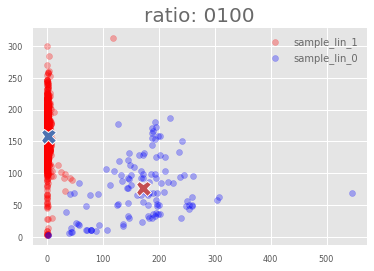

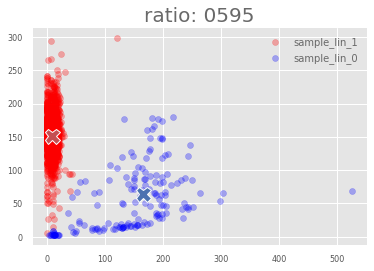

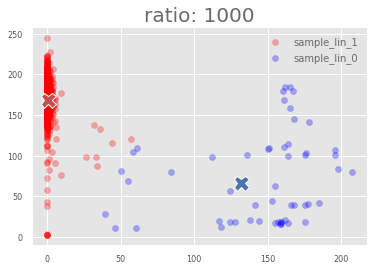

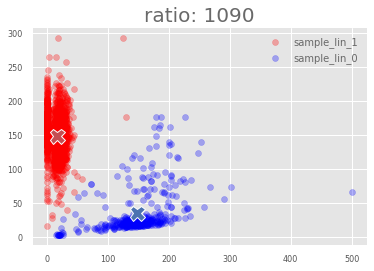

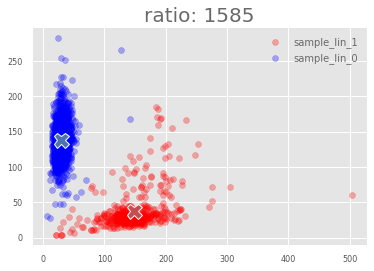

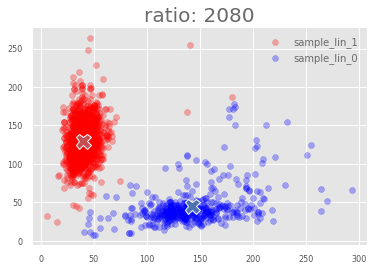

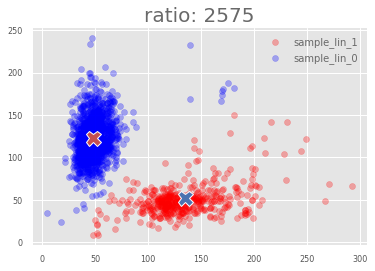

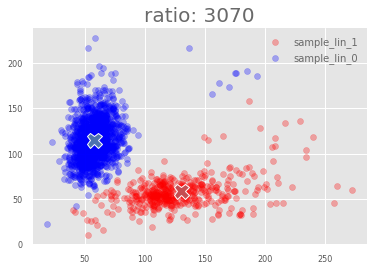

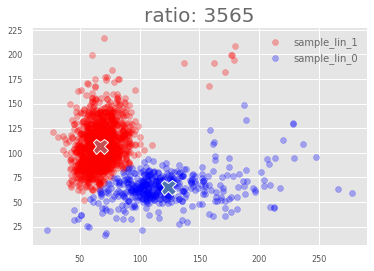

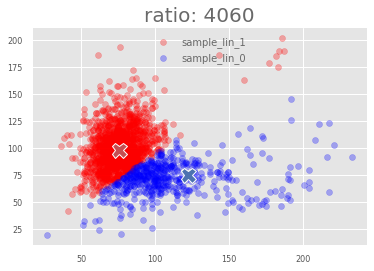

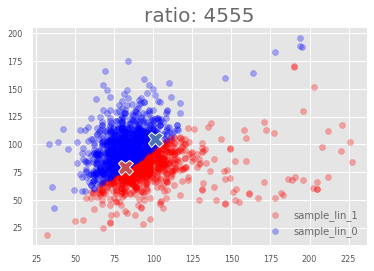

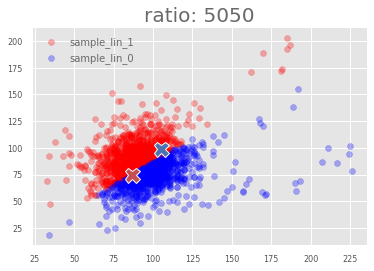

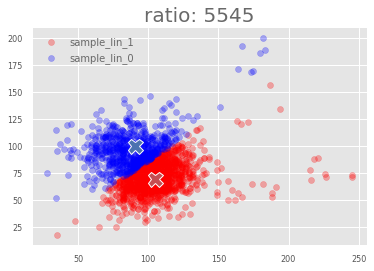

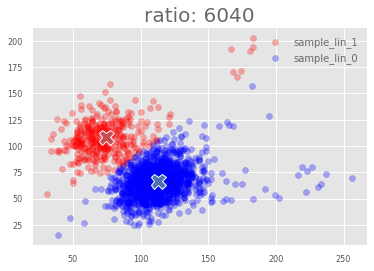

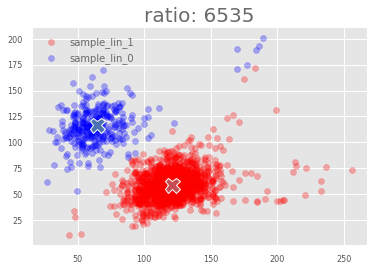

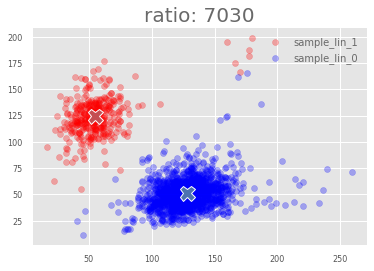

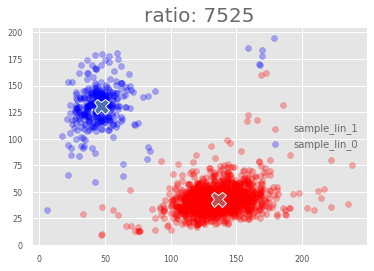

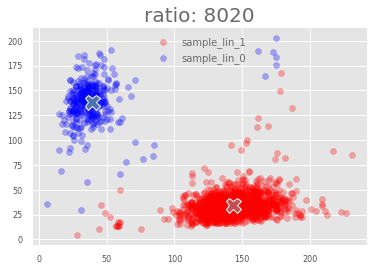

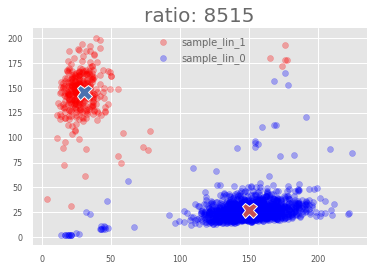

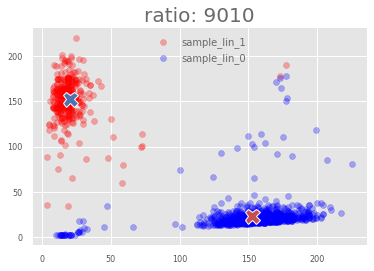

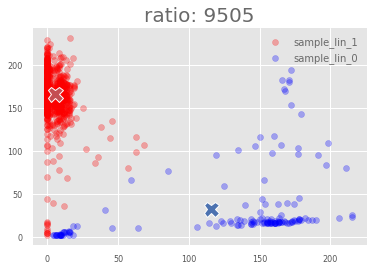

In [70]:
print(frac_MSE(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH))

In [11]:
#removing the 0100 and 1000 6040, 5050case
y_true = [0.8633651551312649, 0.1011378002528445, 0.7554125219426565, 0.20933977455716588, 0.6681818181818182, 0.2986167615947925, 
          # 0.5873648264086511, 0.3963963963963964, 0.5011990407673861, 0.47477064220183485, 0.5932203389830508, 0.38841567291311757, 
          0.6951219512195121, 0.2962962962962963, 0.7953216374269005, 0.20057803468208094, 0.9061461794019934, 0.12028608582574772]
y_pred = [0.7660500659768188, 0.23408824816297552, 0.7659220199852712, 0.2368329200364438, 0.7633326746158897, 0.248175728926683, 
          # 0.7502904174077132, 0.2759160643977226, 0.7268216992632079, 0.3190932149543465, 0.7520835761491568, 0.2726061158130421, 
          0.7637465557502369, 0.24760025372757327, 0.7659445772369651, 0.2352338544977916, 0.7660500659768188, 0.23408824816297552]
print(len(y_true))
print(len(y_pred))
mean_squared_error(y_true, y_pred, squared=False)

12
12


0.08232703363298553

<h1>Confusion matrix

In [31]:
def confusion_map(y, y_pred, title):
    cf_matrix = confusion_matrix(y, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plt.title(title)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [56]:
def confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=False):
    with open(NAME_FILE, 'r') as f:
        sample_list = [line.rstrip('\n') for line in f]

    sample_list_json=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.results.json')
        string = ''.join([letter for letter in x] )
        sample_list_json.append(string)
        
    sample_list_vcf=[]
    for i,x in enumerate(sample_list):
        x = list(x)
        x.append('.vcf.gz')
        string = ''.join([letter for letter in x] )
        sample_list_vcf.append(string)

    ratio = []
    for i in sample_list_json:
        temp = i.split('-')
        ratio.append(temp[2])
    
    ratio1=[]
    for i in ratio:
        temp = i.split('.')
        ratio1.append(temp[0])

    ratio = ratio1

    pos_lin_0 = {'rifampicin':0, 'isoniazid':1, 'ethambutol':2}
    pos_lin_1 = {'rifampicin':0, 'streptomycin':1, 'isoniazid':2, 'ethionamide':3}
    
    ratio_list = []
    f1_list = []



    for j, vcf, ratio in zip(sample_list_json, sample_list_vcf, ratio):
        JSON_FILE = os.path.join(JSON_FILE_PATH, j)
        tb_out_, cut_off = tb_profiler_pred(JSON_FILE)

        if ratio == '0100': 
            lin_ = [0,0,0,1,1,1,1] #lineage1 with rifampicin, streptomycin, isoniazid, ethionamide resistance
        elif ratio == '1000':
            lin_ = [1,1,1,0,0,0,0] #lineage4 with rifampicin, isoniazid, ethambutol resistance
        else:
            lin_ = [1,1,1,1,1,1,1]


        VCF_FILE = os.path.join(VCF_FILE_PATH, vcf)
        model_out_, gm, km_freqs = model_pred(VCF_FILE, tail_cutoff=cut_off)

        strain0 = []
        strain1 = []
        strainU = []

        json_results = json.load(open(JSON_FILE))

        for var in json_results['dr_variants']:
            cluster = assign_variant_to_distrib(km_freqs,var['freq'])
            if cluster == 0:
                var['probs']= cluster
                strain0.append(var)
            elif cluster == 1:
                var['probs']= cluster
                strain1.append(var)
            else:
                var['probs']= cluster[1:]
                strainU.append(var)


        strain_0 = [(v['drugs'][0]['drug']) for v in strain0]
        strain_1 = [(v['drugs'][0]['drug']) for v in strain1]
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        if 'ethambutol' in strain_1:
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]

        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            strain_1 = [(v['drugs'][0]['drug']) for v in strain0]
            strain_0 = [(v['drugs'][0]['drug']) for v in strain1]

        # strain_0 = list(set(strain_0))
        # strain_1 = list(set(strain_1))
        
        # print(ratio)
        # print(strain_0)
        # print(strain_1)
        
        strain_0_pred = [0]*3
        if 'streptomycin' in strain_0 or 'ethionamide' in strain_0:
            print(ratio,'strain_0_error', strain_0)
        else:
            for d in strain_0:
                strain_0_pred[pos_lin_0[d]] = 1

        strain_1_pred = [0]*4
        if 'ethambutol' in strain_1:
            print(ratio,'strain_1_error', strain_1)
        else:
            for d in strain_1:
                strain_1_pred[pos_lin_1[d]] = 1
        
        strain_pred = []
        strain_pred.extend(strain_0_pred)
        strain_pred.extend(strain_1_pred)
        f1 = f1_score(lin_, strain_pred)
        if output == True:
            confusion_map(lin_, strain_pred, ratio)
            print(f'f1-{ratio}:', f1)
        
        # print(lin_)
        # print(strain_pred)


        
        ratio_list.append(ratio)
        f1_list.append(f1)

    return ratio_list, f1_list

f1-0100: 0.8571428571428571
f1-0595: 0.6
f1-1000: 1.0
f1-1090: 0.6
f1-1585: 0.923076923076923
f1-2080: 0.923076923076923
f1-2575: 0.923076923076923
f1-3070: 0.923076923076923
f1-3565: 0.923076923076923
f1-4060: 0.8333333333333333


/tmp/ipykernel_90155/3199226064.py:37: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



f1-4555: 0.7272727272727273
5050 strain_0_error ['rifampicin', 'rifampicin', 'streptomycin', 'isoniazid', 'ethambutol']
f1-5050: 0.25
5545 strain_1_error ['rifampicin', 'streptomycin', 'isoniazid', 'ethambutol']
f1-5545: 0.4444444444444445
f1-6040: 0.923076923076923
f1-6535: 0.923076923076923
f1-7030: 0.923076923076923
f1-7525: 0.923076923076923
f1-8020: 0.923076923076923
f1-8515: 0.923076923076923
f1-9010: 0.6
f1-9505: 0.6


(['0100',
  '0595',
  '1000',
  '1090',
  '1585',
  '2080',
  '2575',
  '3070',
  '3565',
  '4060',
  '4555',
  '5050',
  '5545',
  '6040',
  '6535',
  '7030',
  '7525',
  '8020',
  '8515',
  '9010',
  '9505'],
 [0.8571428571428571,
  0.6,
  1.0,
  0.6,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.8333333333333333,
  0.7272727272727273,
  0.25,
  0.4444444444444445,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.923076923076923,
  0.6,
  0.6])

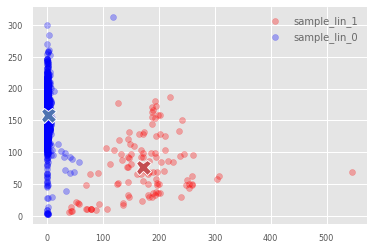

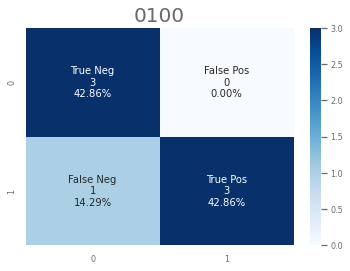

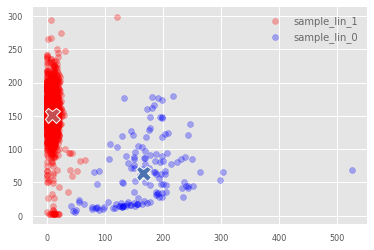

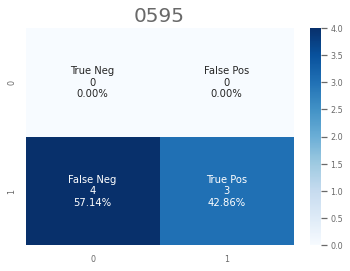

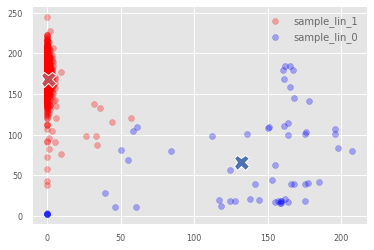

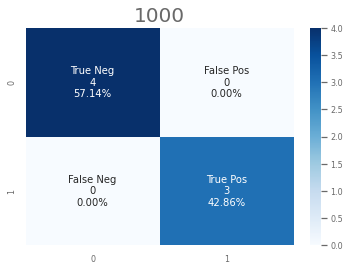

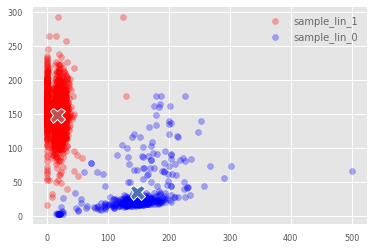

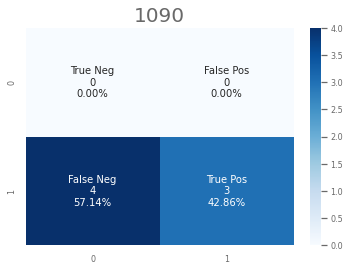

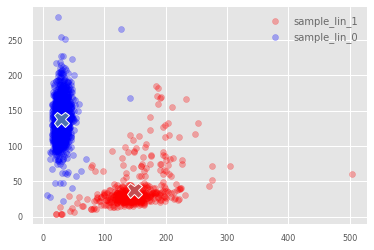

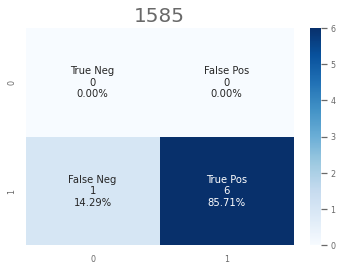

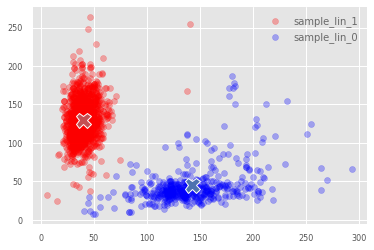

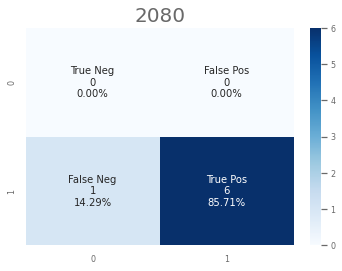

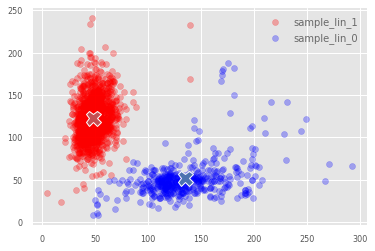

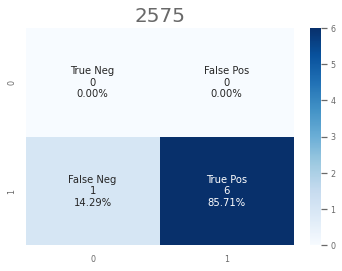

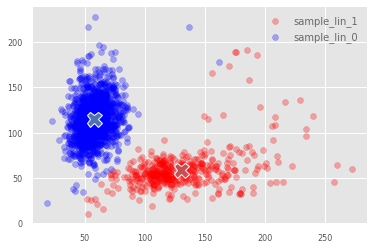

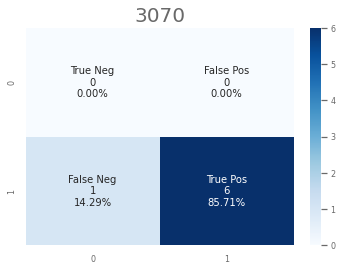

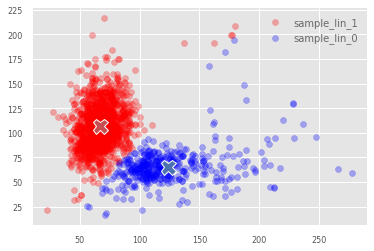

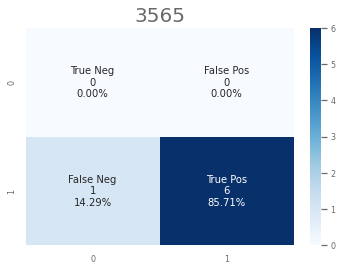

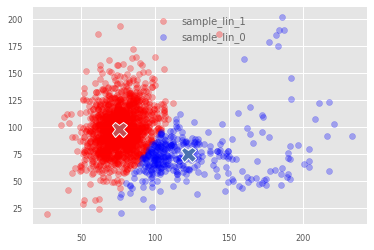

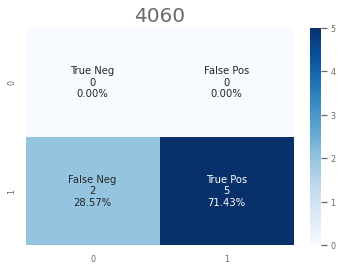

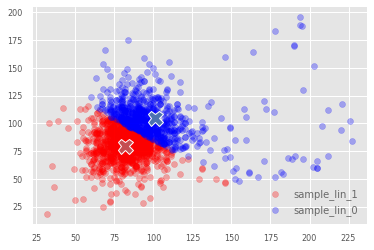

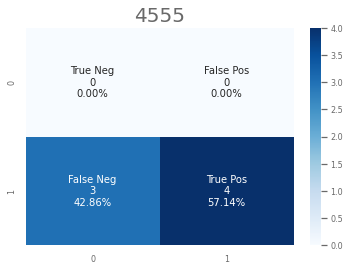

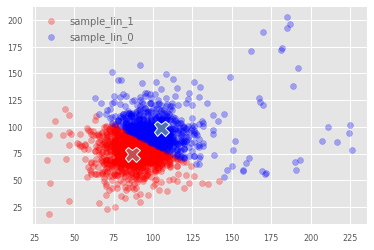

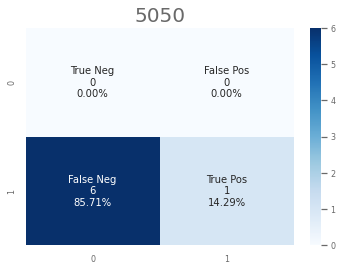

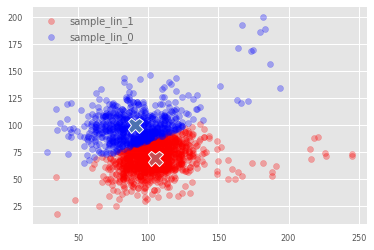

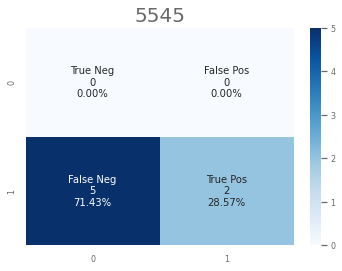

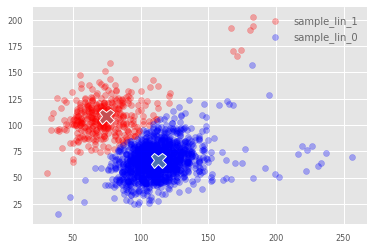

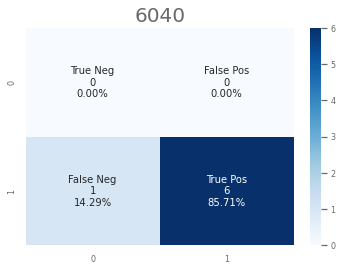

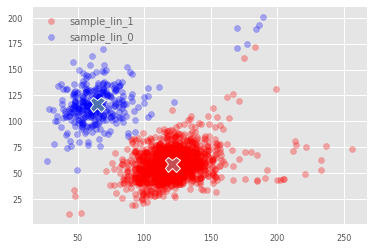

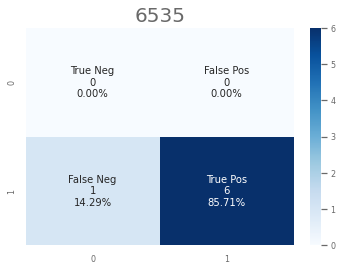

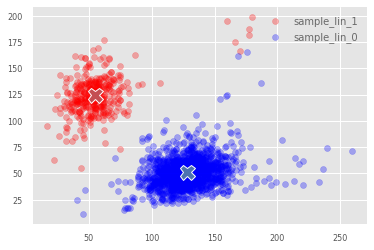

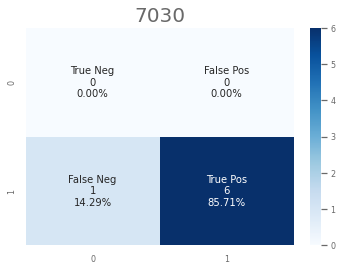

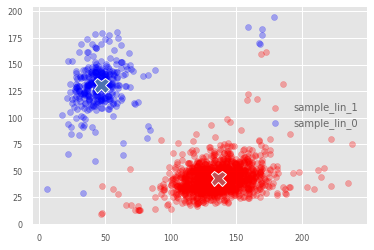

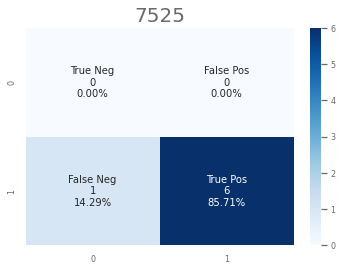

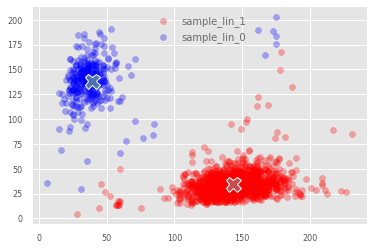

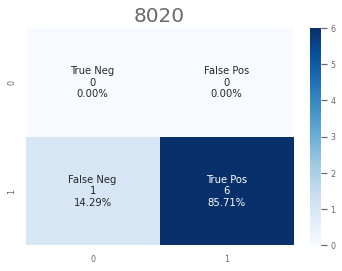

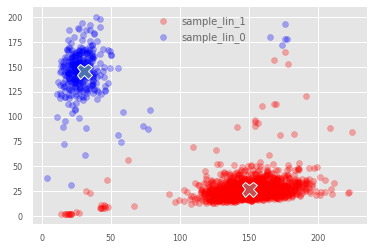

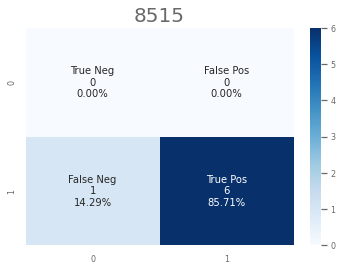

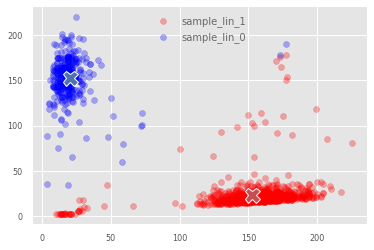

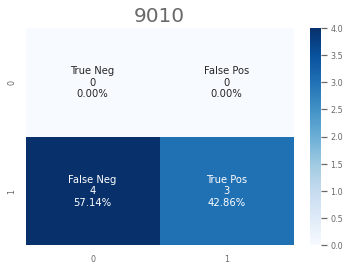

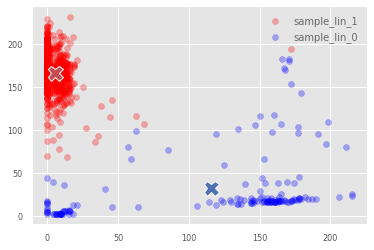

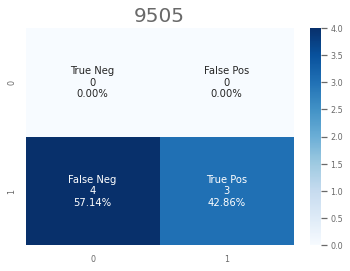

In [57]:
confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH, output=True)

In [63]:
def plot_f1_bar(ratio, f1, title='F1 score'):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ratio ,y=f1, mode='lines',))
    
    fig.update_layout(
        title=title,
        xaxis_title="Strain Ratio",
        yaxis_title="F1",
        legend_title="",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    fig.show()
    

ratio, f1 = confusion_mat(NAME_FILE=NAME_FILE, JSON_FILE_PATH=JSON_FILE_PATH, VCF_FILE_PATH=VCF_FILE_PATH)    

plot_f1_bar(ratio, f1)

IndentationError: expected an indented block after function definition on line 1 (4235804793.py, line 19)

In [ ]:
def plot_gm(gm,data):
    gm.covariances_[0][0][0]
    std0 = np.sqrt(gm.covariances_[0][0][0]) #(n_components, n_features, n_features)
    print('std0:',std0)
    mu0 = gm.means_[0][0]
    print(mu0)
    std1 = np.sqrt(gm.covariances_[1][0][0]) #component 1?
    print('std1:',std1)
    mu1 = gm.means_[1][0]
    print(mu1)
    x = np.linspace(0, 1, 100)
    p0 = norm.pdf(x, mu0, std0)
    p1 = norm.pdf(x, mu1, std1)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Histogram(x=[x[0] for x in data]),secondary_y=False)
    fig.add_trace(go.Scatter(x=x, y=p0, mode='lines'),secondary_y=True)
    fig.add_trace(go.Scatter(x=x, y=p1, mode='lines'),secondary_y=True)
    fig.show()

In [ ]:
def plot_gaussian():
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            pos.append(int(row[0]))
            freqs.append([afs[1]])

        mean_ = np.mean([x[0] for x in freqs])
        std_ = np.std([x[0] for x in freqs])
        print('mean:', mean_)
        print('std:', std_)
        print('2sd up', mean_-2*std_)
        print('2sd down', mean_+2*std_)

        print('skew:', skew([x[0] for x in freqs]))
        print('kurtosis:', kurtosis([x[0] for x in freqs]))


        fig = make_subplots()
        fig.add_trace(go.Histogram(x=[x[0] for x in freqs]),secondary_y=False)
        fig.add_vline(mean_-2*std_, line_dash='dash',line_color='red')
        fig.add_vline(mean_+2*std_, line_dash='dash',line_color='red')

        fig.show()



In [ ]:
plot_gaussian()

In [ ]:
def vcf_to_mix_model(vcf_file,plot=False,tail_cutoff=0.05,title="AF Histogram",return_freqs = False):
    pos = []
    freqs = []
    with open('mix_infection.csv', 'w') as f:
        subprocess.run("bcftools view -c 1 -m2 -M2 -T ^new_exclusion.bed %s | bcftools query -f '%%POS\\t%%REF\\t%%ALT[\\t%%GT\\t%%AD\\n]'" % vcf_file, shell=True, stdout=f, text=True)

#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe

    with open('mix_infection.csv', 'r') as f:
        for l in f:
            row = l.strip().split()
            ads = [int(x) for x in row[4].split(",")]
            afs = [x/sum(ads) for x in ads]
            if afs[1]>1-tail_cutoff or afs[1]<tail_cutoff:
                continue
            pos.append(int(row[0]))
            freqs.append([afs[1]])
        # freqs = [[0.7],[0.6],[0.4]]    
    gm = GaussianMixture(n_components=2, random_state=0).fit(freqs)
    if plot:
        plot_gm(gm,freqs)
    if return_freqs:
        return (gm,list(zip(pos,freqs)))
    else:
        return gm



In [ ]:
gm = vcf_to_mix_model(vcf_file,plot=True,tail_cutoff=0.1)


In [ ]:
json_results = json.load(open(json_file))
strain0 = []
strain1 = []
strainU = []

for var in json_results['dr_variants']:
    cluster = assign_variant_to_distrib(gm,var['freq'])
    if cluster[0] == 0:
        var['probs']= cluster
        strain0.append(var)
    elif cluster[0] == 1:
        var['probs']= cluster
        strain1.append(var)
    else:
        var['probs']= cluster[1:]
        strainU.append(var)

In [ ]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain0])
for x in strain0:
    for y in x['drugs']:
        print(y['drug'])

In [ ]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strain1])
for x in strain1:
    for y in x['drugs']:
        print(y['drug'])


In [22]:
print([(v['gene'],v['change'],v['freq'],v['probs']) for v in strainU])
for x in strainU:
    for y in x['drugs']:
        print(y['drug'])

[]
